In [1]:
import os
import re
import en_ner_bc5cdr_md
import spacy
import copy
import pandas as pd
import numpy as np
import evaluate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset, DatasetDict
import torch 
from transformers import TrainingArguments, Trainer
from torch.optim import AdamW


# Set a random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
spacy.util.fix_random_seed(seed)

# Get paths for data and labels
cwd  = os.getcwd()
processed_path = os.path.join(cwd, "Data/preprocessed-data")
labels_path_beth = os.path.join(cwd,"Data/concept_assertion_relation_training_data","beth","ast")
data_path_beth = os.path.join(cwd,"Data/concept_assertion_relation_training_data","beth","txt")
labels_path_partners = os.path.join(cwd,"Data/concept_assertion_relation_training_data","partners","ast")
data_path_partners = os.path.join(cwd,"Data/concept_assertion_relation_training_data","partners","txt")
labels_path_test = os.path.join(cwd,"Data/reference_standard_for_test_data","ast")
data_path_test = os.path.join(cwd,"Data/test_data")
print('beth ast path', labels_path_beth)
print('beth txt path', data_path_beth)
print('partners ast path', labels_path_partners)
print('partners txt path', data_path_partners)
print('test ast path', labels_path_test)
print('test txt path', data_path_test)

beth ast path C:\Users\kcaro\Documents\GitHub\clinical-adapter\Data/concept_assertion_relation_training_data\beth\ast
beth txt path C:\Users\kcaro\Documents\GitHub\clinical-adapter\Data/concept_assertion_relation_training_data\beth\txt
partners ast path C:\Users\kcaro\Documents\GitHub\clinical-adapter\Data/concept_assertion_relation_training_data\partners\ast
partners txt path C:\Users\kcaro\Documents\GitHub\clinical-adapter\Data/concept_assertion_relation_training_data\partners\txt
test ast path C:\Users\kcaro\Documents\GitHub\clinical-adapter\Data/reference_standard_for_test_data\ast
test txt path C:\Users\kcaro\Documents\GitHub\clinical-adapter\Data/test_data


In [2]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.
    Returns clean text
    
    Steps :
    - Removes HTML tags
    - Removes punctuation
    - lowers text
    """
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    text = text.strip().lower()
    text = re.sub(r'[^\x00-\x7f]',r'', text) 
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    text = " ".join(text.split())
    
    return text

In [3]:
def remove_adjacent_periods(text):
    """
    Takes a text string
    Returns the text string without adjacent periods (see 'Dr.' to 'Dr' below while keeping end period)
    
    For example:
    input: 'Admitted directly to OR from ambulance transfer and underwent cabg x3 with Dr. Howard on 06-13 .'
    output: 'Admitted directly to OR from ambulance transfer and underwent cabg x3 with Dr Howard on 06-13 .'

    This is needed for preventing the sentencizer from splitting on periods that are inside sentences.
    
    """
    pattern = re.compile(r'(?<=\S)\.')
    modified_text = re.sub(pattern, '', text)
    
    return modified_text

In [4]:
def list_files_in_directory(directory_path):
    """
    Takes the path to the records.txt files
    Returns a list of the names of the records in each path
    """
    ignore = ['.DS_Store']
    files = os.listdir(directory_path)
    files = [file for file in files if os.path.isfile(os.path.join(directory_path, file)) and file not in ignore]
    files = [file[:-4] for file in files]
    
    return files


notes_beth = list_files_in_directory(data_path_beth)
notes_partners = list_files_in_directory(data_path_partners)
notes_test = list_files_in_directory(data_path_test)

In [5]:
def load_record_content_dict(notes_list, data_path):
    """
    Takes the list of names of the records and the path to the data records.txt files
    
    Returns a dictionary containing the record_name associated with all the text in the record.txt file:
    content_dict = {record: <all text in the record.txt file>}
    
    eg. 
    content_dict = {'record-105': 'Admission Date :\n2017-06-13\nDischarge Date :\n2017...( End of Report )'}
    
    """
    content_notes = {}
    for note in notes_list:
        _file = os.path.join(data_path, note + '.txt')
        with open(_file) as f:
            content = f.read()
            content_notes[note] = content
    return content_notes


beth_content_dict = load_record_content_dict(notes_beth, data_path_beth)
partners_content_dict = load_record_content_dict(notes_partners, data_path_partners)
test_content_dict = load_record_content_dict(notes_test, data_path_test)

# Merge the content dictionaries into one
training_content_dict = {**beth_content_dict, **partners_content_dict}
all_content_dict = {**training_content_dict, **test_content_dict}

# Print the number of records for each dictionary
print("number of beth training records:", len(beth_content_dict))
print("number of partners training records:", len(partners_content_dict))
print("number of all test records:", len(test_content_dict))
print("number of combined beth and partners records:", len(training_content_dict))
print("number of all combined records:", len(all_content_dict))

number of beth training records: 73
number of partners training records: 97
number of all test records: 256
number of combined beth and partners records: 170
number of all combined records: 426


In [6]:
def load_record_labels_dict(notes_list, labels_path):
    """
    Takes the list of names of the records and the path to the data records.txt files
    
    Returns a dictionary containing the record_name and all the text in the record.ast file:
    labels_dict = {record: <all text in the record.ast file>}
    
    For example:
    labels_dict = {'record-105': 'c="left basilar atelectasis" 55:6 55:8||t="problem"||a="present"\nc="ventral ...'}
    
    """
    labels_notes = {}
    for note in notes_list:
        _file = os.path.join(labels_path, note + '.ast')
        with open(_file) as f:
            content = f.read()
            line_dict = {}
            for line in content:
                
                
                labels_notes[note] = content
            
    f.close()
    return labels_notes


beth_labels_dict  = load_record_labels_dict(notes_beth, labels_path_beth)
partners_labels_dict = load_record_labels_dict(notes_partners, labels_path_partners)
test_labels_dict = load_record_labels_dict(notes_test, labels_path_test)

# # Merge the labels dictionaries into one
training_labels_dict = {**beth_labels_dict, **partners_labels_dict}
all_labels_dict = {**training_labels_dict, **test_labels_dict}

# Print the number of records conatining labels for each dictionary
print("number of beth records with labels:", len(beth_labels_dict))
print("number of partners records with labels:", len(partners_labels_dict))
print("number of test records with labels:", len(test_labels_dict))
print("number of combined beth and partners records with labels:", len(training_labels_dict))
print("number of all combined records with labels:", len(all_labels_dict))

number of beth records with labels: 72
number of partners records with labels: 96
number of test records with labels: 255
number of combined beth and partners records with labels: 168
number of all combined records with labels: 423


In [7]:
# Print the records that don't have any labels because they are blank records
keys_unique_to_beth_dict = set(beth_content_dict.keys()) - set(beth_labels_dict.keys())
keys_unique_to_partners_dict = set(partners_content_dict.keys()) - set(partners_labels_dict.keys())
keys_unique_to_test_dict = set(test_content_dict.keys()) - set(test_labels_dict.keys())
print('the following records have no cooresponding labels (the .ast files are blank):')
print()
print("records in beth data without any labels:", keys_unique_to_beth_dict)
print("records in partners data without any labels:", keys_unique_to_partners_dict)
print("records in test data without any labels:", keys_unique_to_test_dict)

the following records have no cooresponding labels (the .ast files are blank):

records in beth data without any labels: {'record-58'}
records in partners data without any labels: {'262182942'}
records in test data without any labels: {'0305'}


In [8]:
def create_labels_dict(labels_dict):
    """
    Takes labels dictionary:
    labels_dict = {record: <all text in the record.ast file>}
    
    Returns a new dictionary of the labels for each record on each line of the record:
    new_labels_dict = {record: {ast_line: {'location': [<list of locations of entity in record.txt file>],
                                           'problem': '<the entity that is the target for assertion classification>',
                                           'assertion:' 'the assertion label'}}}

    For example:
    new_labels_dict = {'record-105': {1 : {'location': [55, 6, 55, 8],
                                           'problem': 'left basilar atelectasis',
                                           'assertion': 'present'}, 
                                      ...
                                      n :  {...}}
    """
    labels_dict_new = {}
    for key in labels_dict:
        lines = labels_dict[key].split("\n")
        line_dict = {}
        i = 1
        for line in lines:
            if line != '':
                ast = line.strip().split('||')
                assertion = re.findall('"([^"]*)"', ast[2])[0]
                entity = re.split(r'" \d+', ast[0])[0][3:]
                loc_section = re.split(r'" (\d)', ast[0])
                loc = "".join([loc_section[1], loc_section[2]])
                start, end = loc.split(' ')
                s_line, s_tok = start.split(':')
                e_line, e_tok = end.split(':')
                line_info = {'location': [int(s_line), int(s_tok), int(e_line), int(e_tok)], 'problem': entity, 'assertion': assertion}
                line_dict[i] = line_info
                i+= 1
        labels_dict_new[key] = line_dict
            
    return labels_dict_new


training_labels = create_labels_dict(training_labels_dict)
test_labels = create_labels_dict(test_labels_dict)
all_labels = create_labels_dict(all_labels_dict)

# Print the numbet of examples in each group of data (combined beth and partaners labels, test labels)
total_training_labels = 0
for record in training_labels:
    for entry in training_labels[record]:
        if 'assertion' in training_labels[record][entry]:
            total_training_labels += 1
    
total_test_labels = 0
for record in test_labels:
    for entry in test_labels[record]:
        if 'assertion' in test_labels[record][entry]:
            total_test_labels += 1

total_labels_all = 0
for record in all_labels:
    for entry in all_labels[record]:
        if 'assertion' in all_labels[record][entry]:
            total_labels_all += 1
    
print("total number of beth/partners assertion labels for data:", total_training_labels)
print("total number of test assertion labels for data:", total_test_labels)
print("total number of all assertion labels for data:", total_labels_all)

total number of beth/partners assertion labels for data: 7073
total number of test assertion labels for data: 12592
total number of all assertion labels for data: 19665


In [9]:
def create_lined_content_dict(content_dict):
    """
    Takes the content dictionary:
    content_dict = {record: <all text in the record.txt file>}

    Returns a new dictionary of the content line-by-line, with a key for each line
    new_content_dict = {'record': {1: <all the text on line 1 of record.txt>,
                                   2: <all the text on line 2 of record.txt>,
                                   ...,
                                   n: <all the text on last line (n) of record.txt>}}

    For example:
    new_content_dict = {'record-105': {1: 'Admission Date :',
                                       2: '2017-06-13',
                                       3: 'Discharge Date :',
                                       ...
                                       153: '( End of Report )'}}
    """
    new_content = {}
    for key in content_dict:
        lines = content_dict[key].split("\n")
        line_dict = {}
        i = 1
        for line in lines:
            line_dict[i] = line
            i += 1
            
        new_content[key] = line_dict
    return new_content

training_content = create_lined_content_dict(training_content_dict)
test_content = create_lined_content_dict(test_content_dict)
all_content = create_lined_content_dict(all_content_dict)

In [10]:
def add_entity_and_assertion(new_labels, new_content):
    """
    Takes the new_content dictionary and the new_label dictionary:
    new_content_dict = {'record': {1: <all the text on line 1 of record.txt>,
                               2: <all the text on line 2 of record.txt>,
                               ...,
                               n: <all the text on last line (n) of record.txt>}}

    Returns a data dictionary that contains the record and each line of the record with infomration for the
    ast_line number, txt_line number, entity, old_line text, new_line text, and ast label.
    data = {'record': {1: {'ast_line': <line number the ast file (matches the key)>,
                           'txt_line': <line number of the txt file where the target entity is located>,
                           'entity': <the target entity (problem to be classified) from the line in the record.ast file>,
                           'old_line': <all the text on the line in record.txt where the target entity is located>,
                           'new_line': <all the text on the line in record.txt where the target entity is located 
                                       with [entity] tokens inserted around the target entity>,
                           'label': <the label of the entity in the text (present, absent, possible, etc.)>},
                           ...
                           n: {...}}

    For example:
    data = {'record-105': {1: {'ast_line': 1,
                               'txt_line': 55,
                               'entity': 'left basilar atelectasis',
                               'old_line': 'There has been interval improvement in left basilar atelectasis .',
                               'new_line': 'There has been interval improvement in [entity] left basilar atelectasis [entity] .',
                               'label': 'present'},
                           ...
                           n: {...}}
    """
    data = {}
    for record in new_labels:
        i = 1
        data[record] = {}
        for key in new_labels[record]:
            s_line = new_labels[record][key]['location'][0]
            s_tok = new_labels[record][key]['location'][1]
            e_line = new_labels[record][key]['location'][2]
            e_tok = new_labels[record][key]['location'][3]
            assertion = new_labels[record][key]['assertion']
            entity = new_labels[record][key]['problem']
            old_line = new_content[record][s_line]
            
#             entity = clean_text(entity)
#             old_line = clean_text(old_line)
            entity = remove_adjacent_periods(entity)
            old_line = remove_adjacent_periods(old_line)
            
            words = old_line.split()
            words.insert(s_tok, '[entity]')
            words.insert(e_tok + 2, '[entity]')
            new_line = ' '.join(words)
            
            data[record][i] = {'ast_line': i, 'txt_line': s_line, 
                               'entity': entity,'old_line': old_line, 
                               'new_line': new_line, 'label': assertion}
            i += 1
        
    return data

training_line_data = add_entity_and_assertion(training_labels, training_content)
test_line_data = add_entity_and_assertion(test_labels, test_content)
all_line_data = add_entity_and_assertion(all_labels, all_content)

In [11]:
# Print the number of examples in each group of data (combined beth and partaners labels, test labels)
total_training_sents = 0
for record in training_line_data:
    for entry in training_line_data[record]:
        if 'new_line' in training_line_data[record][entry]:
            total_training_sents += 1
    
total_test_sents = 0
for record in test_line_data:
    for entry in test_line_data[record]:
        if 'new_line' in test_line_data[record][entry]:
            total_test_sents += 1
            
total_sents = 0
for record in all_line_data:
    for entry in all_line_data[record]:
        if 'new_line' in all_line_data[record][entry]:
            total_sents += 1
    
print("total number new_line in training data:", total_training_sents)  
print("total number new_line in test data:", total_test_sents)
print("total number of new_line in all data:", total_sents)

total number new_line in training data: 7073
total number new_line in test data: 12592
total number of new_line in all data: 19665


In [12]:
def get_data_by_line(data):
    """
    Takes line_data dictionary
    Returns line data dataframe
    """
    record_dfs = []
    for record, info in data.items():
        df = pd.DataFrame.from_dict(info, orient='index')
        df['record'] = record
        record_dfs.append(df)
    final_df = pd.concat(record_dfs).reset_index(drop=True)
    final_df = final_df[['record', 'ast_line', 'txt_line', 'entity', 'new_line', 'label']]

    return final_df

training_line_data_df = get_data_by_line(training_line_data)
test_line_data_df = get_data_by_line(test_line_data)
all_line_data_df = get_data_by_line(all_line_data)

In [13]:
def filter_data(data_df):
    """
    Takes dataframe
    Returns filtered dataframe with only present, absent, possible and dropped null rows
    """
    allowed_labels = ['present', 'absent', 'possible']
    filtered_df = data_df[data_df['label'].isin(allowed_labels)]
    filtered_df = filtered_df.dropna()
    filtered_df.reset_index(inplace=True, drop=True)
    
    return filtered_df

training_line_data_filtered_df = filter_data(training_line_data_df)
test_line_data_filtered_df = filter_data(test_line_data_df)
all_line_data_filtered_df = filter_data(all_line_data_df)

In [14]:
# OPTION 1: Use line data
"""
Pros: Clean approach, uses all the data, no duplicates created
Cons: Lines are extremely varaible in size, some entities on lines by themselves (no context for assertion task)
"""
all_line_data_filtered_df.to_csv(processed_path + '/ast_line_data.csv', index=False)
all_line_data_filtered_df

,record,ast_line,txt_line,entity,new_line,label
0,record-105,1,55,left basilar atelectasis,There has been interval improvement in [entity...,present
1,record-105,2,143,ventral hernia,HTN [entity] ventral hernia [entity] right nep...,present
2,record-105,3,26,htn,[entity] HTN [entity] elev chol right facial d...,present
3,record-105,4,68,spontaneous echo contrast,No [entity] spontaneous echo contrast [entity]...,absent
4,record-105,5,21,80% lm lesion,Cath at Kindred/North Shore today showed [enti...,present
...,...,...,...,...,...,...
18392,0477,57,38,constrictive pericarditis,Most recently he was admitted to an outside ho...,present
18393,0477,58,74,communication with the intestines,This showed no [entity] communication with the...,absent
18394,0477,59,38,adult respiratory distress syndrome,Most recently he was admitted to an outside ho...,present
18395,0477,60,41,his gunshot wound,He had previous substernal gastric bypass beca...,present


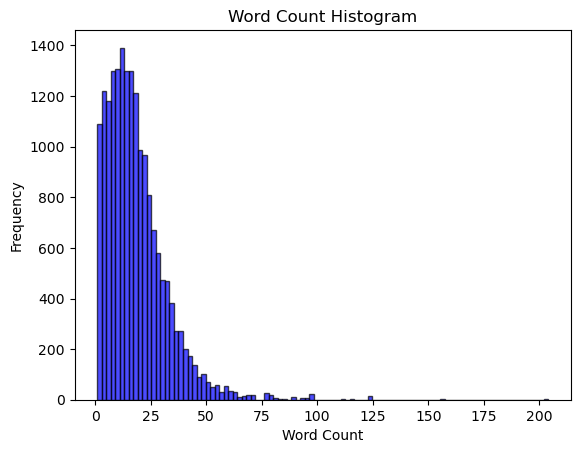

In [15]:
# Use for evaluating OPTION 1

word_counts = all_line_data_filtered_df['new_line'].apply(lambda x: len(x.split()))-2
plt.hist(word_counts, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Histogram')
plt.show()

In [16]:
# word_counts[word_counts == 98]

In [17]:
# all_line_data_filtered_df['new_line'].iloc[3678]

In [18]:
# conda search -c conda-forge spacy

CREATING DATA WITH SENTENCIZER

In [19]:
def records_to_sentences(content_dict):
    """
    Takes the content dictionary with the record and full text content for the record:
    content_dict = {record: <all text in the record.txt file>}
    
    Returns sentences_dict with the record and the text broken by sentence number using the spacey sentencer.
    
    For example:
    sentences_dict = {'record-106': {1:'Admission Date : 2015...after exercise .',
                                     2: 'Pt had been in her usual state of health and performed here regular exercises .',
                                     3: 'After returning to her room she w noted SSCP without radiation .',
                                     ...}}
    """
    nlp1 = spacy.load("en_ner_bc5cdr_md",disable = ['parser'])
    nlp1.add_pipe('sentencizer')

    sentences_dict = {}
    for key in content_dict:
        sentences_dict[key] = {}
        record_text = content_dict[key]
        record_text = remove_adjacent_periods(record_text)
        docs = nlp1(record_text)
        i = 1
        for s in docs.sents:
            sentence = str.strip(str(s))
            sentence = sentence.replace("\n"," ")
#             sentence = clean_text(sentence)

            sentences_dict[key][i] = sentence
            i += 1

    return sentences_dict

training_sentences_dict = records_to_sentences(training_content_dict)
test_sentences_dict = records_to_sentences(test_content_dict)
all_sentences_dict = records_to_sentences(all_content_dict)

In [20]:
def update_data(data, sentences_dict): 
    """
    Takes the data dictionary and the sentences_dict dictionary
    
    Returns a sentencizer_dict that includes a processed line, which is the sentencizer sentence with the new_line that
    contains the [entity] tokens inserted as well as a label key to classify the entity.
    
    For example:
    sentencizer_dict = {'record-105': {...,
                                       3: {'ast_line': 3,
                                           'txt_line': 26,
                                           'entity': 'htn',
                                           'old_line': 'HTN elev chol right facial droop with metal plate secondary to GSW 
                                                        to face right nephrectomy',
                                           'new_line': '[entity] HTN [entity] elev chol right facial droop with metal plate
                                                        secondary to GSW to face right nephrectomy',
                                           'label': 'present',
                                           'processed': 'Past Medical History : ventral hernia [entity] HTN [entity] elev 
                                                         chol right facial droop with metal plate secondary to GSW to face 
                                                         right nephrectomy Social History : current smoker Family History 
                                                         : not given Physical Exam: Not done , taken to OR direct from 
                                                         ambulance transfer .'},
                                        ...}}
    """
    for record in data:
        for ast_line in data[record]:
            entity = data[record][ast_line]['entity']
            old_line = data[record][ast_line]['old_line']
            new_line = data[record][ast_line]['new_line']

            # Look at every sentence in the record and store it if it matches the old_line
            for sent in sentences_dict[record]:
                full_sentence = sentences_dict[record][sent]
                if old_line in full_sentence:
                    proc_sent = full_sentence.replace(old_line, new_line)
                    data[record][ast_line]['processed'] = proc_sent
    return data

sentencizer_training_data = update_data(training_line_data, training_sentences_dict)
sentencizer_test_data = update_data(test_line_data, test_sentences_dict)
sentencizer_all_data = update_data(all_line_data, all_sentences_dict)

In [21]:
def count_missing_proc(data):
    count = 0
    for record in data:
        for i in data[record]:
            if 'processed' not in data[record][i]:
#                 print(f"Item {i} in {record} does not have the key 'processed'")
#                 print("ast_line:", data[record][i]['ast_line'])
#                 print("txt_line:", data[record][i]['txt_line'])
#                 print("old_line:", data[record][i]['old_line'])
#                 print("new_line:", data[record][i]['new_line'])
#                 print("entity:", data[record][i]['entity'])
#                 print("label:", data[record][i]['label'])
#                 print()
#                 data[record][i]['processed'] = data[record][i]['new_line']
                count += 1
    return count

count = count_missing_proc(sentencizer_all_data)
count

361

In [22]:
def get_data_by_sentencizer(data):
    record_dfs = []
    for record, info in data.items():
        df = pd.DataFrame.from_dict(info, orient='index')
        df['record'] = record
        record_dfs.append(df)
    final_df = pd.concat(record_dfs).reset_index(drop=True)
    final_df = final_df[['record', 'ast_line', 'txt_line', 'entity', 'processed', 'label']]

    return final_df

training_sentencizer_data_df = get_data_by_sentencizer(sentencizer_training_data)
test_sentencizer_data_df = get_data_by_sentencizer(sentencizer_test_data)
all_sentencizer_data_df = get_data_by_sentencizer(sentencizer_all_data)
training_sentencizer_data_filtered_df = filter_data(training_sentencizer_data_df)
test_sentencizer_data_filtered_df = filter_data(test_sentencizer_data_df)
all_sentencizer_data_filtered_df = filter_data(all_sentencizer_data_df)

In [23]:
# OPTION 2: Use sentencizer data
"""
Pros: larger sentences (gives context for assertion)
Cons: more complex approach, sentencizer takes time to run, sentencizer requires removing adjacent periods, 
      some long sentences full of header of record, some small sentences due to periods on same line, some
      data will need to be reoved due to no exact match for line (line split by sentencizer)
"""

all_sentencizer_data_filtered_df.to_csv(processed_path + '/ast_sentencizer_data.csv', index=False)
all_sentencizer_data_filtered_df

,record,ast_line,txt_line,entity,processed,label
0,record-105,1,55,left basilar atelectasis,There has been interval improvement in [entity...,present
1,record-105,2,143,ventral hernia,Disp : *14 Tablet( s )* Refills : *0* Discharg...,present
2,record-105,3,26,htn,Past Medical History : ventral hernia [entity]...,present
3,record-105,4,68,spontaneous echo contrast,No [entity] spontaneous echo contrast [entity]...,absent
4,record-105,5,21,80% lm lesion,Cath at Kindred/North Shore today showed [enti...,present
...,...,...,...,...,...,...
18042,0477,57,38,constrictive pericarditis,Most recently he was admitted to an outside ho...,present
18043,0477,58,74,communication with the intestines,This showed no [entity] communication with the...,absent
18044,0477,59,38,adult respiratory distress syndrome,Most recently he was admitted to an outside ho...,present
18045,0477,60,41,his gunshot wound,He had previous substernal gastric bypass beca...,present


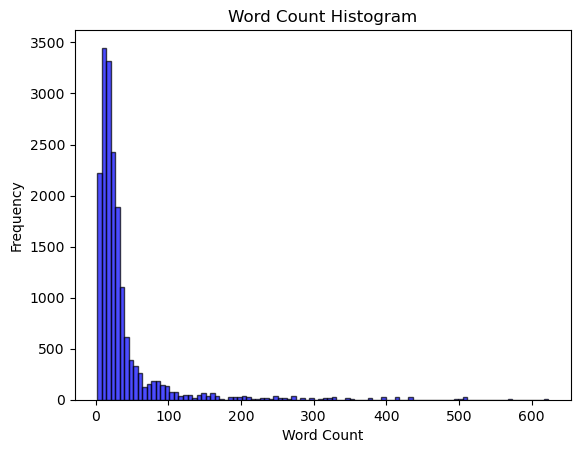

In [24]:
# Use for evaluating OPTION 2

word_counts = all_sentencizer_data_filtered_df['processed'].apply(lambda x: len(x.split()))-2
plt.hist(word_counts, bins=100, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Histogram')
plt.show()

In [ ]:
# OPTION 3: Use n-tokens data - INCOMPLETE
"""
Pros: Clean approach, uses all the data, no duplicates created
Cons: Lines are extremely varaible in size, some entities on lines by themselves (no context for assertion task)
"""

In [118]:
# def add_entity_and_assertion_n_tokens(new_labels, new_content, n):
#     """
#     Takes the new_content dictionary and the new_label dictionary:
#     new_content_dict = {'record': {1: <all the text on line 1 of record.txt>,
#                                2: <all the text on line 2 of record.txt>,
#                                ...,
#                                n: <all the text on last line (n) of record.txt>}}

#     Returns a data dictionary that contains the record and each line of the record with infomration for the
#     ast_line number, txt_line number, entity, old_line text, new_line text, and ast label.
#     data = {'record': {1: {'ast_line': <line number the ast file (matches the key)>,
#                            'txt_line': <line number of the txt file where the target entity is located>,
#                            'entity': <the target entity (problem to be classified) from the line in the record.ast file>,
#                            'old_line': <all the text on the line in record.txt where the target entity is located>,
#                            'new_line': <all the text on the line in record.txt where the target entity is located 
#                                        with [entity] tokens inserted around the target entity>,
#                            'label': <the label of the entity in the text (present, absent, possible, etc.)>},
#                            ...
#                            n: {...}}

#     For example:
#     data = {'record-105': {1: {'ast_line': 1,
#                                'txt_line': 55,
#                                'entity': 'left basilar atelectasis',
#                                'old_line': 'There has been interval improvement in left basilar atelectasis .',
#                                'new_line': 'There has been interval improvement in [entity] left basilar atelectasis [entity] .',
#                                'label': 'present'},
#                            ...
#                            n: {...}}
#     """
#     data = {}
#     for record in new_labels:
#         i = 1
#         data[record] = {}
#         for key in new_labels[record]:
#             s_line = new_labels[record][key]['location'][0]
#             s_tok = new_labels[record][key]['location'][1]
#             e_line = new_labels[record][key]['location'][2]
#             e_tok = new_labels[record][key]['location'][3]
#             assertion = new_labels[record][key]['assertion']
#             entity = new_labels[record][key]['problem']
#             old_line = new_content[record][s_line]
            
# #             entity = clean_text(entity)
# #             old_line = clean_text(old_line)
#             entity = remove_adjacent_periods(entity)
#             old_line = remove_adjacent_periods(old_line)
#             words = old_line.split()
#             words.insert(s_tok, '[entity]')
#             words.insert(e_tok + 2, '[entity]')
#             new_line = ' '.join(words)
            
# #             print(new_content[record][s_line-1])
#             ntok_line = words[s_tok:e_tok + 3]
            
#             print(len(words))
#             print(words)
#             print(words[s_tok:e_tok + 3])
#             print(words[0:s_tok])
#             print()
            
#             data[record][i] = {'ast_line': i, 'txt_line': s_line, 
#                                'entity': entity,'old_line': old_line, 
#                                'new_line': new_line, 'label': assertion}
#             i += 1
        
#     return data

# training_ntok_data = add_entity_and_assertion_n_tokens(training_labels, training_content, 3)
# # test_ntok_data = add_entity_and_assertion_n_tokens(test_labels, test_content, 3)
# # all_ntok_data = add_entity_and_assertion_n_tokens(all_labels, all_content, 3)

Test the data

In [47]:
data_to_test = "Line Data"

In [48]:
if data_to_test == "Line Data":
    # LINE DATA TEST
    # Test on 20% of data. Split to training, validation, and test sets
    all_line_data_filtered_df_frac = all_line_data_filtered_df.sample(frac=0.2).copy()


    X = all_line_data_filtered_df_frac['new_line']
    y = all_line_data_filtered_df_frac['label']

    X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=seed, stratify=y_test_valid)

    print(f"X shape {X.shape} y shape : {y.shape}")
    print(f"X_train shape {X_train.shape} y_train shape : {y_train.shape}")
    print(f"X_val shape {X_valid.shape} y_val shape : {y_valid.shape}")
    print(f"X_test shape {X_test.shape} y_test shape : {y_test.shape}")
    
elif data_to_test == "Sentencizer Data":
    # SENTENCIZER DATA TEST
    # Test on 20% of data. Split to training, validation, and test sets
    all_sentencizer_data_filtered_df_frac = all_sentencizer_data_filtered_df.sample(frac=0.2).copy()


    X = all_sentencizer_data_filtered_df_frac['processed']
    y = all_sentencizer_data_filtered_df_frac['label']

    X_train, X_test_valid, y_train, y_test_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)
    X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=seed, stratify=y_test_valid)

    print(f"X shape {X.shape} y shape : {y.shape}")
    print(f"X_train shape {X_train.shape} y_train shape : {y_train.shape}")
    print(f"X_val shape {X_valid.shape} y_val shape : {y_valid.shape}")
    print(f"X_test shape {X_test.shape} y_test shape : {y_test.shape}")

else:
    print(data_to_test, "not a valid choice")

X shape (3679,) y shape : (3679,)
X_train shape (2943,) y_train shape : (2943,)
X_val shape (368,) y_val shape : (368,)
X_test shape (368,) y_test shape : (368,)


In [49]:
print("Encoding Labels .....")
encoder = LabelEncoder()
encoder.fit(y_train)
y_train_encode = np.asarray(encoder.transform(y_train))
y_valid_encode = np.asarray(encoder.transform(y_valid))
y_test_encode = np.asarray(encoder.transform(y_test))

Encoding Labels .....


In [50]:
train_df = pd.DataFrame(X_train)
valid_df = pd.DataFrame(X_valid)
test_df = pd.DataFrame(X_test)

train_df['label'] = y_train_encode.tolist()
valid_df['label'] = y_valid_encode.tolist()
test_df['label'] = y_test_encode.tolist()

print(train_df.head())

ds = DatasetDict ({
 'train': Dataset.from_pandas(train_df),
 'validation': Dataset.from_pandas(valid_df),
 'test': Dataset.from_pandas(test_df)
})

                                                new_line  label
8282   On prednisone or sometime after it was discont...      2
9587   [entity] No gag [entity] provoked , but biting...      2
14067  He was readmitted tot he CMED CSRU for respira...      2
5525   He had episodes of [entity] bradycardia [entit...      2
16046  On the day prior to discharge she complained o...      2


In [51]:
# FOR MAC
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# FOR NVIDIA GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device in use:", device)

# If using GPU, set seed for CUDA operations
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device in use: cuda


In [52]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoModel 
tokenizer_clinical_bio  = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT", model_max_length=150)
model_clinical = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_Discharge_Summary_BERT", 
                                                                    num_labels=3,
                                                                    id2label={0: 'PRESENT', 1: 'ABSENT', 2:'POSSIBLE'})

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at C:\Users\kcaro/.cache\huggingface\hub\models--emilyalsentzer--Bio_Discharge_Summary_BERT\snapshots\affde836a50e4d333f15dae9270f5a856d59540b\config.json
Model config BertConfig {
  "_name_or_path": "emilyalsentzer/Bio_Discharge_Summary_BERT",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file vocab.txt from cache at C:\Users\kcaro/.cache\huggingface\hub\models--emilyalsentzer--B

In [53]:
model_clinical = model_clinical.to(device)

In [54]:
special_tokens_dict = {"additional_special_tokens": ["[entity]"]}
num_added_toks = tokenizer_clinical_bio.add_special_tokens(special_tokens_dict,False)

print("We have added", num_added_toks, "tokens")
# Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e., the length of the tokenizer.
model_clinical.resize_token_embeddings(len(tokenizer_clinical_bio))

Assigning ['[entity]'] to the additional_special_tokens key of the tokenizer


We have added 1 tokens


Embedding(28997, 768)

In [55]:
if data_to_test == "Line Data":
    # LINE DATA TEST
    def tokenize_function(example):
        return tokenizer_clinical_bio(example["new_line"],   padding="max_length", truncation=True)
    
    # LINE DATA TEST
    # Takes ds dataset and tokenizes
    tokenized_ds = ds.map(tokenize_function, batched=True)
    tokenized_ds = tokenized_ds.rename_column("label", "labels")
    tokenized_ds = tokenized_ds.remove_columns(["new_line"])
    tokenized_ds = tokenized_ds.remove_columns(["__index_level_0__"])
    tokenized_ds.set_format("torch")
    
elif data_to_test == "Sentencizer Data":
    # SENTENCIZER DATA TEST
    def tokenize_function(example):
        return tokenizer_clinical_bio(example["processed"],   padding="max_length", truncation=True)
    
    # SENTENCIZER DATA TEST
    # Takes ds dataset and tokenizes
    tokenized_ds = ds.map(tokenize_function, batched=True)
    tokenized_ds = tokenized_ds.rename_column("label", "labels")
    tokenized_ds = tokenized_ds.remove_columns(["processed"])
    tokenized_ds = tokenized_ds.remove_columns(["__index_level_0__"])
    tokenized_ds.set_format("torch")
else:
    print(data_to_test, "not a valid choice")

Map:   0%|          | 0/2943 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

Map:   0%|          | 0/368 [00:00<?, ? examples/s]

In [37]:
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [38]:
training_args = TrainingArguments(
    output_dir="clinbert_trainer", 
    evaluation_strategy="epoch", 
    learning_rate=1e-5, 
    num_train_epochs=1,
    logging_dir="./logs",
    log_level="info",
    logging_steps=10,
    report_to="all")

trainer = Trainer(
    model=model_clinical,
    args=training_args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    compute_metrics=compute_metrics)

In [39]:
trainer.train()

C:\Users\kcaro\miniconda3\envs\clinical-adapter\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2887
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 361
  Number of trainable parameters = 108313347


Epoch,Training Loss,Validation Loss,Accuracy
1,0.323100,0.324868,0.905817


***** Running Evaluation *****
  Num examples = 361
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=361, training_loss=0.48032553044052334, metrics={'train_runtime': 138.8804, 'train_samples_per_second': 20.788, 'train_steps_per_second': 2.599, 'total_flos': 222541534271700.0, 'train_loss': 0.48032553044052334, 'epoch': 1.0})